# Attempt at Offsides Detection

In [39]:
# Check if GPU is being used
!nvidia-smi

Mon Nov 25 11:05:13 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   44C    P8             20W /  170W |    3182MiB /  12288MiB |     20%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [40]:
import os
import sys

# Run on GPU
os.environ["ONNXRUNTIME_EXECUTION_PROVIDER"] = "CUDAExecutionProvider"
project_root = os.path.abspath('..')
sys.path.append(project_root)

# Get Imports

In [41]:
import supervision as sv
from common.team import TeamClassifier
from tqdm import tqdm
import numpy as np
from inference import get_model
from dotenv import load_dotenv
import torch
import cv2
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch, draw_pitch_voronoi_diagram
from sports.configs.soccer import SoccerPitchConfiguration

# Initialize Constants

In [42]:
# Setup paths for source & target videos
# Change to dynamic inputs for cloud deployment
# SOURCE_VIDEO_PATH = "../videos/08fd33_4.mp4"
SOURCE_VIDEO_PATH = "../videos/soccer_video_offside_3.mp4"
TARGET_VIDEO_PATH = "08fd33_4_result_1.mp4"
DEVICE = 'cuda'
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3
OFFSIDE_ID = 4
STRIDE = 30

CONFIG = SoccerPitchConfiguration()


# Load Env

In [43]:
# Load env variables
load_dotenv()
ROBOFLOW_API_KEY = os.getenv("ROBOFLOW_API_KEY")

# ID for roboflow detection model created
PLAYER_DETECTION_MODEL_ID = "football-players-detection-3zvbc/12"

# Load Player/Ball model
PLAYER_DETECTION_MODEL = get_model(
    model_id=PLAYER_DETECTION_MODEL_ID,
    api_key=ROBOFLOW_API_KEY
)

# Not enough epochs on own model -- grab model better trained model from Roboflow
# https://universe.roboflow.com/roboflow-jvuqo/football-field-detection-f07vi/model/15

# Load Pitch Detection Model
PITCH_DETECTION_MODEL_ID ="football-field-detection-f07vi/15"
PITCH_DETECTION_MODEL = get_model(
    model_id=PITCH_DETECTION_MODEL_ID, 
    api_key=ROBOFLOW_API_KEY
)

# Setup Annotators

In [44]:
# Setup class for displaying Ellipse around players
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

# Setup class for displaying triangle over ball
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    base=20,
    height=17,
)

# Setup class for labeling box annotations
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER,
)

# Create Vertext Annotator for pitch detection
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8
)

# Create edge annotations using SoccerPitchConfiguration
edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('00BFFF'),
    thickness=2,
    edges=CONFIG.edges
)

# External Functions

In [45]:
# Function to extract cropped images from video to identify player teams
# @Params: video_path<str>
# @Return: crops<arr>
def extract_crops(source_video_path: str):

    # Generate frames from source video
    # Stride: Only use every nth frame
    frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

    crops = []

    # Loop through each frame generated
    for  frame in tqdm(frame_generator, desc="collection crops"):

        # Infer object type (ie. person) with minimum confidence
        # Covert to standard format
        # Remove overlapping detections
        # Filter detections by class --> only keep players
        result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)
        detections = detections.with_nmm(threshold=0.5, class_agnostic=True)
        detections = detections[detections.class_id == PLAYER_ID]
        crops += [
            # Out of the box feature that crops out based on the box coordinates (xyxy)
            sv.crop_image(frame, xyxy)
            for xyxy
            in detections.xyxy
        ]
    
    return crops

In [46]:
def resolve_goalkeepers_team_id(players_detections: sv.Detections, goalkeepers_detections: sv.Detections) -> np.ndarray:
    
    # Players will have 0 or 1 depending on the team they belong to --> from TeamClassifier
    # Get the coordinates of goalkeeper and player detections from the lower center of bounding box
    goalkeepers_xy = goalkeepers_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)

    # Filter out players based on class id (which team they are on)
    # Find the average position of players in each team
    # This can also be used to determine the direction of attack for each team
    team_0_centroid = players_xy[players_detections.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players_detections.class_id == 1].mean(axis=0)

    # Loop over goalkeepers
    # Find distance of each goalkeeper from each team centroid
    # Goal keeper will belong to team they are closest to on average
    goalkeepers_team_ids = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_ids.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_ids)

In [ ]:
def resolve_offside_player(players_detections: sv.Detections, pitch_players_xy: np.ndarray) -> np.ndarray:
    
    ### Double check team side logic when using different videos with different sides of the pitch being attacked ###

    # Get average center positions on the x-axis for each team
    # Lower number defends the left side of the field while attacking the right
    # Higher number defends the right side of the field while attacking the left
    team_0_center = pitch_players_xy[players_detections.class_id == 0][0].mean(axis=0) # Defending
    team_1_center = pitch_players_xy[players_detections.class_id == 1][0].mean(axis=0) # Attacking

    
    # Swap team class_ids and centroid values to ensure team 0 is always defending left side of field
    # Team 0 centroid must be less than team 1 centroid
    if team_0_center > team_1_center:
        temp = team_1_center
        team_0_center = team_1_center
        team_1_center = temp

        for i in players_detections.class_id:

            j = 0

            if i == 0:
                j = 1
            if i == 1:
                j = 0

            players_detections.class_id[i] = j


    print("Player Classes After: ", players_detections.class_id)
    print("Team 0 Center: ", team_0_center)
    print("Team 1 Center: ", team_1_center)

    longest_x = 0 # Initialize to min distance
    shortest_x = 12000 # Initialize to max distance
    longest_x_id = 0
    shortest_x_id = 0

    print(pitch_players_xy[players_detections.class_id == 0])
    
    # Find the player furthest to the right and their id
    for i in range(len(pitch_players_xy)):
        if pitch_players_xy[i][0] > longest_x:
            longest_x = pitch_players_xy[i][0]
            longest_x_id = i

    # Find the player furthest to the left and their id
    for j in range(len(pitch_players_xy)):
        if pitch_players_xy[j][0] < shortest_x:
            shortest_x = pitch_players_xy[j][0]
            shortest_x_id = j
    
    offside_ids = []

    print("Longest X: ", longest_x)
    print("Shortest X: ", shortest_x)
    print("Longest X ID: ", longest_x_id)
    print("Shortest X ID: ", shortest_x_id)

    print("OG PLAYER DETECT ID: ", players_detections.class_id)
    print("TEST: ", players_detections.class_id[longest_x_id])

    # Get furthest left and right for each team
    # Since team 0 is always left --> if team 0 isnt furthest left then team 1 is offsides
    # Since team 1 is always right --> if team 1 isnt furthest right then team 0 is offsides

    if players_detections.class_id[shortest_x_id] != 0:
        offside_ids.append(shortest_x_id)
    
    if players_detections.class_id[longest_x_id] != 1:
        offside_ids.append(longest_x_id)

    print("Offside IDS: ", offside_ids)
    
    new_class_ids = players_detections.class_id

    # Loop through all offside ids and set to OFFSIDE_ID
    for i in offside_ids:
        print(f"Player {i} is offside")
        new_class_ids[i] = OFFSIDE_ID

    # Return new list of class ids including the offside players
    return new_class_ids


In [48]:
# Transform perspective of pitch to 2D plane
class ViewTransformer:

    # Initialize points in float32 format
    # Calculate homography matrix for 2D perspective transformation
    # @Params: source<np.ndarray>, target<np.ndarray>
    # @Return: None
    def __init__(self, source: np.ndarray, target: np.ndarray):
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m, _ = cv2.findHomography(source, target)

    # Points exist in 2 dimensions
    # Expand points to 3 dimensions to match homography matrix
    # Remove extra dimension once completed
    # @Params: source<np.ndarray>, target<np.ndarray>
    # @Return: np.ndarray
    def transform_points(self, points: np.ndarray) -> np.ndarray:

        if points.size == 0:
            return points
        
        if points.shape[1] != 2:
            raise ValueError("Points must have shape (n, 2)")
        
        
        points = points.reshape(-1, 1, 2).astype(np.float32)
        points = cv2.perspectiveTransform(points, self.m)
        return points.reshape(-1, 2).astype(np.float32)

# Slice Video Frames

In [49]:
crops = extract_crops(SOURCE_VIDEO_PATH)
team_classifier = TeamClassifier()
team_classifier.fit(crops)

# Track newly detected instances of players/balls
tracker = sv.ByteTrack()
tracker.reset()

# Create video source and where to store completed video
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)

# For testing only grab a single frame and draw on it for results
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame=next(frame_generator)

player_result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
player_detections = sv.Detections.from_inference(player_result)

# Detect pitch on each frame with at least 30% confidence
# Store keypoints infered from frame result
pitch_result = PITCH_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(pitch_result)

collection crops: 18it [00:03,  4.96it/s]
Embedding extraction: 11it [00:39,  3.58s/it]


# Get & Classify Detections

In [50]:
# Get detections for ball from each frame
ball_detections = player_detections[player_detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)


# Set all detections to not include ball
# Remove overlapping detections
# Adjust class id of all remaining detections by 1 to account for BALL_ID having different detection
# Add tracker to all detections besides ball 
all_detections = player_detections[player_detections.class_id != BALL_ID]
all_detections = all_detections.with_nmm(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(all_detections)

# Define player, goalkeeper and referees from within all_detections
# Grab only frames with detected players
players_detections = all_detections[all_detections.class_id == PLAYER_ID]
goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
referee_detections = all_detections[all_detections.class_id == REFEREE_ID]

referee_detections.class_id -= 1

# Team Prediction

In [51]:
# Predict team for each player using team_classifier
player_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(player_crops)

# Define goalkeepers_detections from within all_detections
# Grab only frames with detected goalkeepers
# Resolve goalkeeper teams by finding closest distance from average team position
goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)

Embedding extraction: 1it [00:02,  2.26s/it]


# Detect Pitch

In [52]:

# Filter out keypoints with confidence less than 0.5
# Create new object with filtered key points
# Create new KeyPoints object with new key point positions
# Filter out low confidence pitch reference points
filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])
pitch_reference_points = np.array(CONFIG.vertices)[filter]

# Pass pitch_reference_Points and frame_reference_points to do transformation
view_transformer = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points,    
)

# Gather all the points together
# Create new KeyPoints object
pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = view_transformer.transform_points(pitch_all_points)
frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])


# Transform Video to 2D Plane

In [53]:
# 2D Plane X is from 0 - 12000

# Filter out keypoints with confidence less than 0.5
# Create new object with filtered key points
# Create new KeyPoints object with new key point positions
# Filter out low confidence pitch reference points
filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])
pitch_reference_points = np.array(CONFIG.vertices)[filter]

# Pass pitch_reference_Points and frame_reference_points to do transformation
view_transformer = ViewTransformer(
    source=frame_reference_points,
    target=pitch_reference_points,    
)

# Get position of ball on a frame
# Frame (x,y) is captured image
# Pitch (x,y) is position of ball on 2D plane
# Transform position to 2D plane
frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_ball_xy = view_transformer.transform_points(frame_ball_xy)

# Get position of players on a frame
# Frame (x,y) is captured image
# Pitch (x,y) is position of player on 2D plane
# Transform position to 2D plane
frame_player_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_players_xy = view_transformer.transform_points(frame_player_xy)

# Get position of referees on a frame
# Frame (x,y) is captured image
# Pitch (x,y) is position of referee on 2D plane
# Transform position to 2D plane
frame_referee_xy = referee_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_referee_xy = view_transformer.transform_points(frame_referee_xy)




# Offside Detection

1. Detect Players
2. Identify Player positions
3. Use homography to transform positions to 2D plane
4. Check if any player is offsides
5. Return offsides player class id
6. Setup new annotation and label, and add it to the specific player with previous class id

If player is further away from defending team centroid than any other player from that centeroid team, he is offside

Can also use goal keeper as point of reference since we know the teams of each gaol keeper to identify defending team?

Option 1: Take goalkeeper X position and identify goal keeper team. Then identify player with x coordinate closest to goal keeper. If team does not match, that player is offsides. Identify both goalkeepers  OR do furthest and closest away from goalkeeper to determine offsides.

If the furstest from the goal keepr is the same as the goal keeper team then they are offside

Option 2: Take all X positions of players and their teams. Take centroids (can easily switch between attack/defense). 

In [ ]:
# Get list of ids -- index of offside player will be 4
# Store new list of ids in players_detections class ids
player_detections.class_id = resolve_offside_player(players_detections, pitch_players_xy)

Player Classes Before:  [0 1 0 1 0 1 0 0 1 0 1 0 1 1 1 0 0 0 1 0]
Player Classes After:  [0 1 0 1 0 1 0 0 1 0 1 0 1 1 1 0 0 0 1 0]
Team 0 Center:  5190.071
Team 1 Center:  6238.6465
[[3972.99    6407.152  ]
 [4996.4316  6862.6533 ]
 [3858.8906  4200.1978 ]
 [4872.3193  4653.9766 ]
 [6178.701   4543.442  ]
 [4813.06    3070.3755 ]
 [3813.8777  1225.8392 ]
 [6799.986   3617.0498 ]
 [6763.517   4780.763  ]
 [2787.7625  4615.8364 ]
 [6695.7007   271.66052]]
Longest X:  6889.466
Shortest X:  2787.7625
Longest X ID:  18
Shortest X ID:  17
OG PLAYER DETECT ID:  [0 1 0 1 0 1 0 0 1 0 1 0 1 1 1 0 0 0 1 0]
TEST:  1
Offside IDS:  []
Outside Func:  [0 1 0 1 0 1 0 0 1 0 1 0 1 1 1 0 0 0 1 0]


# Draw Pitch

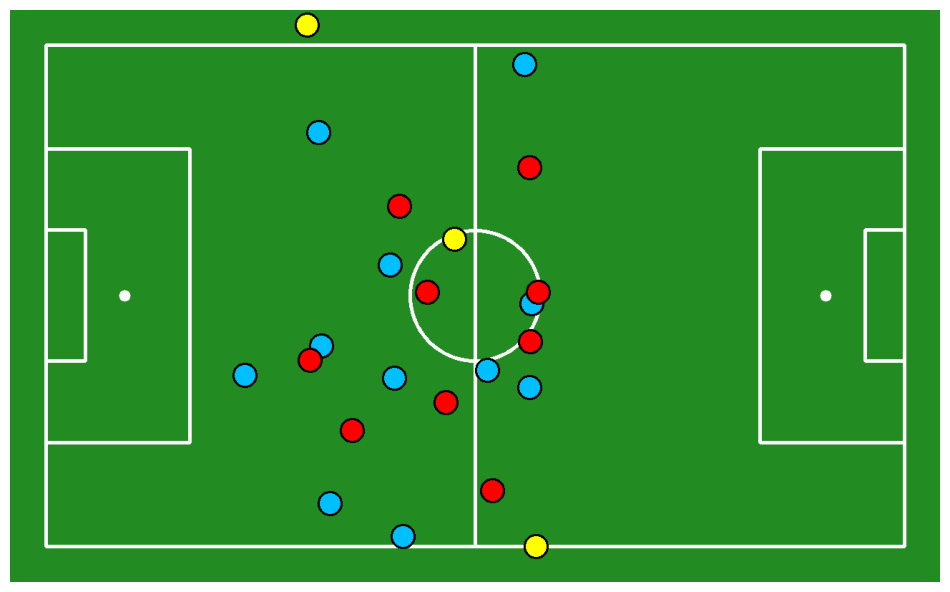

In [55]:
# Draw points on the flat 2D pitch we made
pitch = draw_pitch(config=CONFIG)
pitch = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.BLACK,
    radius=10,
    pitch=pitch
)

# Draw Team 1
pitch = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 0],
    face_color=sv.Color.from_hex("00BFFF"),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=pitch
)

# Draw Team 2
pitch = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 1],
    face_color=sv.Color.from_hex("#ff0000"),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=pitch
)

# Draw Offsides
pitch = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 4],
    face_color=sv.Color.from_hex("#f633ff"),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=pitch
)

# Draw Referee
# Can pass just pitch(x,y) to xy because there is no team classifications for referees
pitch = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_referee_xy,
    face_color=sv.Color.from_hex("#ffff00"),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=pitch
)

sv.plot_image(pitch)

# Display Frame

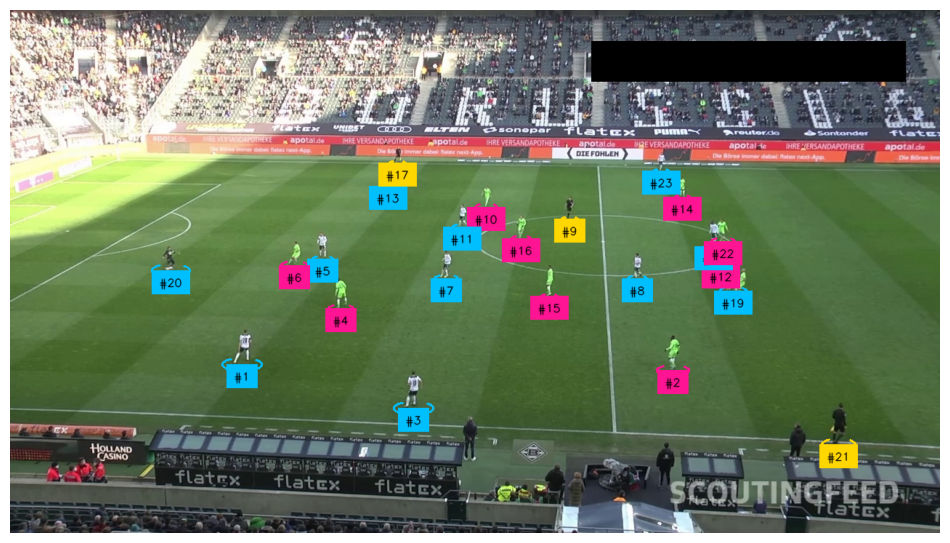

In [58]:
# Redefine all_detections to merge players and goalkeepers
all_detections = sv.Detections.merge([players_detections, goalkeepers_detections, referee_detections])

# Ensure class_id values are integers
all_detections.class_id = np.array(all_detections.class_id, dtype=int)

# Update tracker label
# Add id to each object being tracked
labels = [
    "Offsides" if class_id == 4 else f"#{tracker_id}"
    for tracker_id, class_id in zip(all_detections.tracker_id, all_detections.class_id)
]

# Set annotated frame to current frame
# Add ellipise & label annotator to all detections (contains players & goalkeepers)
# Add triangle annotator to ball detections
annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(annotated_frame, all_detections)
annotated_frame = label_annotator.annotate(annotated_frame, all_detections, labels=labels)
annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)

# Plot single frame image for testing results
sv.plot_image(annotated_frame)

## FIX THE COLOR OF THE OFFSIDE ANNOTATION